In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import pandas as pd
import os, re, json
import numpy as np
import math

def _safe_div(a, b):
    return a / b if b not in (0, np.nan) else np.nan

def summarize_single_config(
    df: pd.DataFrame,
    *,
    runtime_col: str = "Runtime (s)",
    run_col: str = "database",      # identifies each workload run (1..5)
    query_col: str = "query_id"     # 1..99
) -> pd.DataFrame:
    """
    Returns one row of metrics:

    Mean Query Runtime Across Workloads (s)
        - Avg, Std, P50, P99 of mean runtime across workload runs

    Repeatability Across Queries
        - Std (s): Avg, P50, P99 (Bessel-corrected)
        - CV (%):  Avg, P50, P99
    """

    sub = df[pd.notna(df[runtime_col])].copy()
    if sub.empty:
        return pd.DataFrame([{
            col: np.nan for col in [
                "Mean Runtime Avg (s)", "Mean Runtime Std (s)",
                "Mean Runtime P50 (s)", "Mean Runtime P99 (s)",
                "Std Avg (s)", "Std P50 (s)", "Std P99 (s)",
                "CV Avg (%)", "CV P50 (%)", "CV P99 (%)",
                "Runs", "Queries"
            ]
        }])

    # --- Across Workloads (each run_col = one workload execution)
    per_run = (sub.groupby(run_col)[runtime_col]
                  .agg(run_mean="mean")
                  .reset_index())

    mean_runtimes = per_run["run_mean"].to_numpy()

    # Bessel-corrected standard deviation of mean runtimes across workloads
    avg_mean_runtime_s = np.mean(mean_runtimes)
    std_mean_runtime_s = np.std(mean_runtimes, ddof=1) if len(mean_runtimes) > 1 else np.nan
    p50_mean_runtime_s = np.percentile(mean_runtimes, 50)
    p99_mean_runtime_s = np.percentile(mean_runtimes, 99)

    # --- Across Queries: each query over multiple runs
    qg = sub.groupby(query_col)[runtime_col]
    q_stats = qg.agg(
        q_mean="mean",
        q_std=lambda x: np.std(x, ddof=1) if len(x) == 5 else np.nan
    ).reset_index()
    q_stats = q_stats.dropna(subset=["q_std"]).reset_index(drop=True)

    q_stats["q_cv_percent"] = 100.0 * q_stats["q_std"] / q_stats["q_mean"]

    std_values = q_stats["q_std"].to_numpy()
    cv_values = q_stats["q_cv_percent"].to_numpy()

    avg_std_s = np.mean(std_values)
    p50_std_s = np.percentile(std_values, 50)
    p99_std_s = np.percentile(std_values, 99)

    avg_cv_pct = np.mean(cv_values)
    p50_cv_pct = np.percentile(cv_values, 50)
    p99_cv_pct = np.percentile(cv_values, 99)

    # --- Combine results
    row = {
        # Mean Query Runtime Across Workloads
        "Mean Runtime Avg (s)": avg_mean_runtime_s,
        "Mean Runtime Std (s)": std_mean_runtime_s,
        "Mean Runtime P50 (s)": p50_mean_runtime_s,
        "Mean Runtime P99 (s)": p99_mean_runtime_s,

        # Repeatability: Std
        "Std Avg (s)": avg_std_s,
        "Std P50 (s)": p50_std_s,
        "Std P99 (s)": p99_std_s,

        # Repeatability: CV
        "CV Avg (%)": avg_cv_pct,
        "CV P50 (%)": p50_cv_pct,
        "CV P99 (%)": p99_cv_pct,

        "Runs": int(per_run.shape[0]),
        "Queries": int(q_stats.shape[0]),
    }

    return pd.DataFrame([row])



# Optional: pretty print / round
def print_single_row(df: pd.DataFrame, dp: int = 2):
    t = df.copy()
    for c in t.columns:
        if pd.api.types.is_numeric_dtype(t[c]):
            t[c] = t[c].map(lambda x: f"{x:.{dp}f}" if pd.notna(x) else "-")
    print(t.to_string(index=False))

_DUR_RE = re.compile(
    r"^\s*(?P<val>[-+]?\d+(\.\d+)?)\s*(?P<unit>ns|us|µs|ms|s|sec|secs|second|seconds|m|min|mins|minute|minutes|h|hr|hrs|hour|hours)?\s*$",
    re.IGNORECASE,
)

def _hms_to_seconds(hms: str) -> float:
    parts = hms.split(":")
    if len(parts) != 3:
        return np.nan
    h, m, s = parts
    try:
        return float(h) * 3600.0 + float(m) * 60.0 + float(s)
    except Exception:
        return np.nan

def parse_duration_to_seconds(x) -> float:
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    if not s:
        return np.nan
    if ":" in s and s.count(":") == 2 and not s.endswith("Z"):
        sec = _hms_to_seconds(s)
        if not np.isnan(sec):
            return sec
    m = _DUR_RE.match(s)
    if m:
        val = float(m.group("val"))
        unit = (m.group("unit") or "s").lower()
        if unit in ("s", "sec", "secs", "second", "seconds"):
            return val
        if unit in ("ms",):
            return val / 1e3
        if unit in ("us", "µs"):
            return val / 1e6
        if unit in ("ns",):
            return val / 1e9
        if unit in ("m", "min", "mins", "minute", "minutes"):
            return val * 60.0
        if unit in ("h", "hr", "hrs", "hour", "hours"):
            return val * 3600.0
    return np.nan

_QFILE_RE = re.compile(r"^q(?P<num>\d+)\.json$", re.IGNORECASE)
_RUN_DIR_RE = re.compile(r"^(?P<base>.+)_(?P<run>\d+)$")   # e.g., lakehouse_BASE_1

def load_trino_times(
    root_dir: str,
    *,
    elapsed_key="elapsedTime",
    execution_key="executionTime",
    planning_key="analysisTime",          # or "planningTime"
    waiting_key="resourceWaitingTime",
    clamp_negative: bool = False
) -> pd.DataFrame:
    """
    Walk `root_dir` (e.g., SF_10) with per-run subdirs like `lakehouse_BASE_1`
    and q*.json files. Returns columns:
      [lakehouse, database, query_id, elapsed_s, execution_s, planning_s,
       resource_waiting_s, elapsed_minus_execution_s]
    """
    rows = []

    with os.scandir(root_dir) as it:
        subdirs = [e for e in it if e.is_dir()]

    for i, d in enumerate(sorted(subdirs, key=lambda e: e.name)):
        run_dir = d.path
        run_name = os.path.basename(run_dir)
        print(run_name)

        m = _RUN_DIR_RE.match(run_name)
        if m:
            lakehouse_base = m.group("base")
            run_idx = int(m.group("run"))
            database_label = f"Run {i}"
        else:
            parts = run_name.rsplit("_", 1)
            lakehouse_base = parts[0] if len(parts) == 2 else run_name
            database_label = "Run ?"

        for fname in sorted(os.listdir(run_dir)):
            qmatch = _QFILE_RE.match(fname)
            if not qmatch:
                continue
            query_id = int(qmatch.group("num"))
            fpath = os.path.join(run_dir, fname)

            try:
                with open(fpath, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception:
                continue

            stats = (data.get("queryStats") or {})
            elapsed_s   = parse_duration_to_seconds(stats.get(elapsed_key))
            execution_s = parse_duration_to_seconds(stats.get(execution_key))
            planning_s  = parse_duration_to_seconds(stats.get(planning_key))
            waiting_s   = parse_duration_to_seconds(stats.get(waiting_key))

            delta = (elapsed_s - execution_s) if (pd.notna(elapsed_s) and pd.notna(execution_s)) else np.nan
            if clamp_negative and pd.notna(delta) and delta < 0:
                delta = 0.0

            rows.append({
                "lakehouse": lakehouse_base,
                "database": database_label,
                "query_id": query_id,
                "elapsed_s": elapsed_s,
                "execution_s": execution_s,
                "planning_s": planning_s,
                "resource_waiting_s": waiting_s,
                "elapsed_minus_execution_s": delta,
            })

    df = pd.DataFrame(rows).sort_values(["lakehouse", "database", "query_id"], kind="stable")
    return df.reset_index(drop=True)

import math
import numpy as np
import pandas as pd

def table_1_latex_row_from_table(
    table: pd.DataFrame,
    platform: str,
    dp: int = 3,
    include_runs_queries: bool = False,
) -> str:
    if not isinstance(table, pd.DataFrame) or table.shape[0] != 1:
        raise ValueError("table must be a single-row pandas DataFrame")

    row = table.iloc[0]

    col_order = [
        "Mean Runtime Avg (s)", "Mean Runtime Std (s)",
        "Std Avg (s)", "Std P50 (s)", "Std P99 (s)",
        "CV Avg (%)", "CV P50 (%)", "CV P99 (%)"
    ]

    def fmt(x):
        if x is None or (isinstance(x, float) and (math.isnan(x) or np.isnan(x))):
            return "-"
        return f"{float(x):.{dp}f}"

    values = [fmt(row.get(c, np.nan)) for c in col_order]

    # Insert the \hspace only before the first numeric entry for alignment
    values[0] = "\\hspace{5pt} " + values[0]

    return f"{platform} &&& " + " & ".join(values) + " \\\\"


MEAN_COL = 'Average Mean Runtime (s)'
STD_Q_COL = 'Average Std. (s) [Queries]'
RANGE_AVG_COL = 'Average Range (s)'
CV_COL = 'Average CV (%)'

OUT_COLS = [
    MEAN_COL,
    'ΔAvg. Mean (%)',
    'ΔStd. (%)',
    'ΔRange (%)',
    'ΔCV',
]

def _pct_change(new, base):
    # robust % change: (new-base)/base * 100
    if pd.isna(base) or pd.isna(new):
        return np.nan
    if base == 0:
        return np.inf if new != 0 else 0.0
    return (float(new) - float(base)) / float(base) * 100.0
    
import math
import pandas as pd
import matplotlib.pyplot as plt

def plot_single_row_metric_bars(
    label_table_pairs,
    metric: str,
    row: int = 0,
    title: str | None = None,
    ylabel: str | None = None,
    value_format: str = "{:.3f}",
    annotate: bool = True,
    rotate_xticks: int | float = 0,
    figsize=(7, 4),
):
    if not label_table_pairs:
        raise ValueError("label_table_pairs is empty.")

    # Validate metric in all tables
    missing = [lab for lab, df in label_table_pairs if metric not in df.columns]
    if missing:
        raise ValueError(f"Metric '{metric}' not found in tables: {missing}")

    labels = []
    values = []
    for lab, df in label_table_pairs:
        if row >= len(df):
            raise IndexError(f"Requested row {row} not in table for '{lab}' (len={len(df)}).")
        val = pd.to_numeric(df.iloc[row][metric], errors="coerce")
        if pd.isna(val):
            raise ValueError(f"Value for metric '{metric}' in '{lab}' row {row} is NaN/invalid.")
        labels.append(lab)
        values.append(float(val))

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(labels, values)  # no explicit colors/styles (per your constraints)

    ax.set_ylabel(ylabel or metric)
    if title:
        ax.set_title(title)
    ax.set_xticklabels(labels, rotation=rotate_xticks)

    if annotate:
        ylim = ax.get_ylim()
        span = ylim[1] - ylim[0] if ylim[1] > ylim[0] else 1.0
        offset = 0.02 * span  # small offset above bar
        for rect, v in zip(bars, values):
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,
                rect.get_height() + offset,
                value_format.format(v),
                ha="center",
                va="bottom",
            )
        ax.set_ylim(ylim[0], max(ylim[1], max(values) + 4 * offset))

    fig.tight_layout()
    return fig, ax

def compare_config_deltas(baseline_df: pd.DataFrame, compare_df: pd.DataFrame, dp: int = 3) -> pd.DataFrame:
    if not isinstance(baseline_df, pd.DataFrame) or baseline_df.shape[0] != 1:
        raise ValueError("baseline_df must be a single-row DataFrame.")
    if not isinstance(compare_df, pd.DataFrame) or compare_df.shape[0] != 1:
        raise ValueError("compare_df must be a single-row DataFrame.")

    base = baseline_df.iloc[0]
    comp = compare_df.iloc[0]

    # --- Compute deltas ---
    delta_mean_runtime = 100 * (comp["Mean Runtime Avg (s)"] - base["Mean Runtime Avg (s)"])/ base["Mean Runtime Avg (s)"]
    delta_cv_avg = 100 * (comp["CV Avg (%)"] - base["CV Avg (%)"])  / base["CV Avg (%)"]
    delta_cv_p50 = 100 *(comp["CV P50 (%)"] - base["CV P50 (%)"])  / base["CV P50 (%)"]
    delta_cv_p99 = 100 *(comp["CV P99 (%)"] - base["CV P99 (%)"])  / base["CV P99 (%)"]

    # --- Build new dataframe ---
    row = dict(comp)
    row.update({
        "Δ Mean Runtime Avg (s)": delta_mean_runtime,
        "ΔCV Avg (pp)": delta_cv_avg,
        "ΔCV P50 (pp)": delta_cv_p50,
        "ΔCV P99 (pp)": delta_cv_p99,
    })

    # --- Round all numeric values to dp ---
    for k, v in row.items():
        if isinstance(v, (int, float, np.floating)):
            if pd.notna(v):
                row[k] = round(float(v), dp)

    return pd.DataFrame([row])

import math
import numpy as np
import pandas as pd

def table_2_latex_row_from_table(
    table: pd.DataFrame,
    platform: str,  # still here in case you use it for multirow logic elsewhere
    *,
    isDelta: bool = False,
    factor_name: str | None = None,  # NEW: label like "External metastore"
    dp: int = 3,
) -> str:
    """
    Generate a LaTeX table row for either a BASELINE or DELTA configuration.

    Parameters
    ----------
    table : pd.DataFrame
        Single-row DataFrame (from summarize_single_config or compare_config_deltas)
    platform : str
        Name of the platform (e.g., "AWS", "Azure", etc.)
    isDelta : bool
        If True, print a Δ (delta) comparison row.
        If False, print a baseline gray header row.
    factor_name : str
        Label of the factor (e.g., "External metastore") for delta rows.
    dp : int
        Decimal places for rounding.

    Returns
    -------
    str : LaTeX-formatted table row
    """
    if not isinstance(table, pd.DataFrame) or table.shape[0] != 1:
        raise ValueError("table must be a single-row pandas DataFrame.")

    row = table.iloc[0]

    def _is_missing(x) -> bool:
        if x is None:
            return True
        try:
            return math.isnan(float(x))
        except (TypeError, ValueError):
            return False

    def fmt(x):
        """Standard formatter for non-delta columns."""
        if _is_missing(x):
            return "-"
        return f"{float(x):.{dp}f}"

    def fmt_delta(x):
        """Formatter for delta columns, e.g. $+~15.746$."""
        if _is_missing(x):
            return "-"
        x = float(x)
        if abs(x) < 10**(-dp):
            return "$0$"
        sign = "+" if x > 0 else "-"
        return f"${sign}~{abs(x):.{dp}f}$"

    # --- BASELINE ROW ---
    if not isDelta:
        latex_line = (
            "\\multicolumn{5}{c}{\\rowcolor{gray!25} (Baseline)} & "
            f"{fmt(row.get('Mean Runtime Avg (s)', np.nan))} & "
            "\\\multicolumn{1}{c}{\textbf{—}} & "
            f"{fmt(row.get('CV Avg (%)', np.nan))} & "
            f"{fmt(row.get('CV P50 (%)', np.nan))} & "
            f"{fmt(row.get('CV P99 (%)', np.nan))} & "
            "\\textbf{—} & \\textbf{—} & \\textbf{—} \\\\"
        )

    # --- DELTA ROW ---
    else:
        if factor_name is None:
            raise ValueError("factor_name must be provided for delta (isDelta=True) rows.")

        # Example desired output:
        # & \textbullet\ External metastore & 43.744 & $+~15.746$ & 21.314 & 19.069 &
        #   61.279 & $+~10.479$ & $+~10.524$ & $+~20.221$ \\
        latex_line = (
            f"& \\textbullet {factor_name} & "
            f"{fmt(row.get('Mean Runtime Avg (s)', np.nan))} & "
            f"{fmt_delta(row.get('Δ Mean Runtime Avg (s)', np.nan))} & "
            f"{fmt(row.get('CV Avg (%)', np.nan))} & "
            f"{fmt(row.get('CV P50 (%)', np.nan))} & "
            f"{fmt(row.get('CV P99 (%)', np.nan))} & "
            f"{fmt_delta(row.get('ΔCV Avg (pp)', np.nan))} & "
            f"{fmt_delta(row.get('ΔCV P50 (pp)', np.nan))} & "
            f"{fmt_delta(row.get('ΔCV P99 (pp)', np.nan))} \\\\"
        )

    return latex_line



In [ ]:
BASE_CLUSTER_PLATFORM = "IDA" # 25-10-04/SF_1000
DATE = "25-10-29"
SF=""
SUB_DIR = f"/SF_{SF}" if SF else "/sf1000"
BASE_FILEPATH = f"{BASE_CLUSTER_PLATFORM}/{DATE}{SUB_DIR}"
directory = f"/mnt/primary/Mini-project/Apache/System/Queries/TPCDS/Time_Workload/Results/{BASE_FILEPATH}"

df_BASELINE = load_trino_times(directory)
print("Done")

In [ ]:
CLUSTER_PLATFORM = "IDA"
DATE = "25-11-05" # "25-08-05"
SUB_DIR ="/fixed"
FILEPATH = f"{CLUSTER_PLATFORM}/{DATE}{SUB_DIR}"
directory = f"/mnt/primary/Mini-project/Apache/System/Queries/TPCDS/Time_Workload/Results/{FILEPATH}"

df_compare = load_trino_times(directory)
print("Done")

In [13]:
BASELINE_table = summarize_single_config(df_BASELINE, run_col="database", query_col="query_id", runtime_col="elapsed_s")
COMPARE_table = summarize_single_config(df_compare, run_col="database", query_col="query_id", runtime_col="elapsed_s")
delta_COMPARE_table = compare_config_deltas(BASELINE_table, COMPARE_table, dp=3)

In [14]:
print(f"{table_2_latex_row_from_table(BASELINE_table, BASE_CLUSTER_PLATFORM , isDelta=False)} %/{BASE_FILEPATH} NEW")
print(f"{table_2_latex_row_from_table(delta_COMPARE_table, 'IDA', isDelta=True, factor_name='Pinned nodes')} %/{FILEPATH} NEW") 

\multicolumn{5}{c}{\rowcolor{gray!25} (Baseline)} & 109.432 & \\multicolumn{1}{c}{	extbf{—}} & 21.634 & 17.895 & 98.652 & \textbf{—} & \textbf{—} & \textbf{—} \\ %/IDA/25-10-29/sf1000 NEW
& \textbullet Pinned nodes & 90.392 & $-~17.399$ & 16.338 & 10.685 & 73.910 & $-~24.483$ & $-~40.290$ & $-~25.080$ \\ %/IDA/25-11-05/fixed NEW


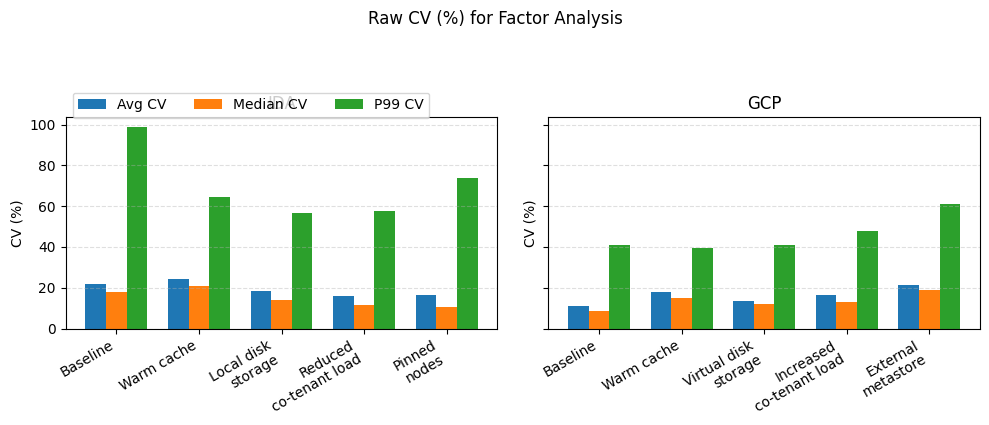

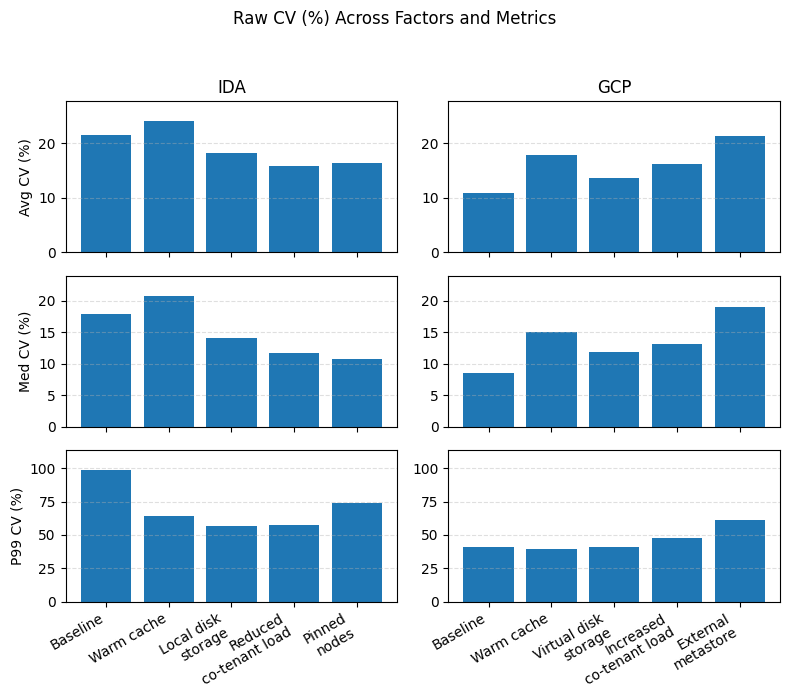

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Hard-coded CV (%) values
# -----------------------------
factors_ida = [
    "Baseline",
    "Warm cache",
    "Local disk\nstorage",
    "Reduced\nco-tenant load",
    "Pinned\nnodes",
]

cv_avg_ida = [21.634, 24.115, 18.182, 15.790, 16.338]
cv_med_ida = [17.895, 20.796, 14.022, 11.752, 10.685]
cv_p99_ida = [98.652, 64.355, 56.496, 57.528, 73.910]

factors_gcp = [
    "Baseline",
    "Warm cache",
    "Virtual disk\nstorage",
    "Increased\nco-tenant load",
    "External\nmetastore",
]

cv_avg_gcp = [10.835, 17.797, 13.664, 16.254, 21.314]
cv_med_gcp = [8.545, 15.057, 11.816, 13.215, 19.069]
cv_p99_gcp = [41.058, 39.370, 40.793, 47.812, 61.279]

# -----------------------------
# Plotting helper
# -----------------------------
def plot_cluster(ax, title, factors, avg, med, p99):
    x = np.arange(len(factors))
    width = 0.25

    ax.bar(x - width, avg,  width, label="Avg CV")
    ax.bar(x,         med,  width, label="Median CV")
    ax.bar(x + width, p99,  width, label="P99 CV")

    ax.set_xticks(x)
    ax.set_xticklabels(factors, rotation=30, ha="right")
    ax.set_ylabel("CV (%)")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

# -----------------------------
# Make the figure
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

plot_cluster(axes[0], "IDA", factors_ida, cv_avg_ida, cv_med_ida, cv_p99_ida)
plot_cluster(axes[1], "GCP", factors_gcp, cv_avg_gcp, cv_med_gcp, cv_p99_gcp)

axes[0].legend(loc="upper left", bbox_to_anchor=(0, 1.15), ncol=3)
fig.suptitle("Raw CV (%) for Factor Analysis", y=1.05)
fig.tight_layout()

# Save for LaTeX
plt.savefig("factor_analysis_cv_raw.pdf", bbox_inches="tight", dpi=300)
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Hard-coded CV (%) values
# -----------------------------
factors_ida = [
    "Baseline",
    "Warm cache",
    "Local disk\nstorage",
    "Reduced\nco-tenant load",
    "Pinned\nnodes",
]

cv_ida = {
    "Avg":  [21.634, 24.115, 18.182, 15.790, 16.338],
    "Med":  [17.895, 20.796, 14.022, 11.752, 10.685],
    "P99":  [98.652, 64.355, 56.496, 57.528, 73.910],
}

factors_gcp = [
    "Baseline",
    "Warm cache",
    "Virtual disk\nstorage",
    "Increased\nco-tenant load",
    "External\nmetastore",
]

cv_gcp = {
    "Avg":  [10.835, 17.797, 13.664, 16.254, 21.314],
    "Med":  [8.545, 15.057, 11.816, 13.215, 19.069],
    "P99":  [41.058, 39.370, 40.793, 47.812, 61.279],
}

metrics = ["Avg", "Med", "P99"]

fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(8, 7), sharex="col"
)

for row, metric in enumerate(metrics):
    # Compute a common y-limit for this metric across both clusters
    all_vals = cv_ida[metric] + cv_gcp[metric]
    y_max = max(all_vals) * 1.15

    # IDA subplot
    ax_ida = axes[row, 0]
    x_ida = np.arange(len(factors_ida))
    ax_ida.bar(x_ida, cv_ida[metric])
    ax_ida.set_ylim(0, y_max)
    if row == 0:
        ax_ida.set_title("IDA")
    ax_ida.set_ylabel(f"{metric} CV (%)")

    # GCP subplot
    ax_gcp = axes[row, 1]
    x_gcp = np.arange(len(factors_gcp))
    ax_gcp.bar(x_gcp, cv_gcp[metric])
    ax_gcp.set_ylim(0, y_max)
    if row == 0:
        ax_gcp.set_title("GCP")

    # Only show x tick labels on bottom row
    if row == len(metrics) - 1:
        ax_ida.set_xticks(x_ida)
        ax_ida.set_xticklabels(factors_ida, rotation=30, ha="right")
        ax_gcp.set_xticks(x_gcp)
        ax_gcp.set_xticklabels(factors_gcp, rotation=30, ha="right")
    else:
        ax_ida.set_xticklabels([])
        ax_gcp.set_xticklabels([])

    # Light grid to make differences easier to see
    ax_ida.grid(axis="y", linestyle="--", alpha=0.4)
    ax_gcp.grid(axis="y", linestyle="--", alpha=0.4)

fig.suptitle("Raw CV (%) Across Factors and Metrics", y=0.99)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save for LaTeX
plt.savefig("factor_analysis_cv_raw_small_multiples.pdf", dpi=300, bbox_inches="tight")
plt.show()
